### Imports

In [1]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np

%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2
from torchviz import make_dot
import pandas as pd

from notebooks.utils import Utils

from train_init_network import PoseNet


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Functions

### Initialization

In [2]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/LND_short', bg_color=[0, 0, 0])
pose = gaussians.get_xyz
w2e = torch.mean(gaussians._xyz, 0).clone().detach()

# with torch.no_grad():  # Ensure no gradient tracking for direct modification
    # gaussians._xyz[:] -= torch.mean(gaussians._xyz, 0)  # translation
# print(gaussians._xyz[:, 2])
print(w2e)
T_wt_homogeneous = torch.cat([w2e, torch.tensor([1.0], device='cuda:0')])
example_camera = sample_cameras[0]
P = example_camera.projection_matrix.to('cuda:0')
print(example_camera.world_view_transform)
print("P\n",P)
import math
tanfovx = math.tan(example_camera.FoVx * 0.5)
tanfovy = math.tan(example_camera.FoVy * 0.5)

focal_length_x = example_camera.image_width / (2 * tanfovx)
focal_length_y = example_camera.image_height / (2 * tanfovy)
K = torch.tensor(
    [
        [focal_length_x, 0, example_camera.image_width / 2.0, 0],
        [0, focal_length_y, example_camera.image_height / 2.0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ],
    device="cuda",
)
print("K:\n", K)
print(example_camera.get_camera_center())
# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/LND_short
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path


/home/iulian/chole_ws/src/drrobot/scene/gaussian_model.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrs = torch.load(os.path.join(os.path.dirname(path), 'lrs.pth'))

tensor([-0.0002,  0.0003,  0.0142], device='cuda:0')
tensor([[-9.6126e-01,  1.7346e-01,  2.1421e-01,  0.0000e+00],
        [-2.7564e-01, -6.0494e-01, -7.4704e-01,  0.0000e+00],
        [-0.0000e+00, -7.7715e-01,  6.2932e-01,  0.0000e+00],
        [-6.4449e-18, -3.5715e-17,  1.9102e-01,  1.0000e+00]])
P
 tensor([[ 2.4328,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4328,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device='cuda:0')
K:
 tensor([[311.3939,   0.0000, 128.0000,   0.0000],
        [  0.0000, 311.3939, 128.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
tensor([-0.0409,  0.1427, -0.1202])


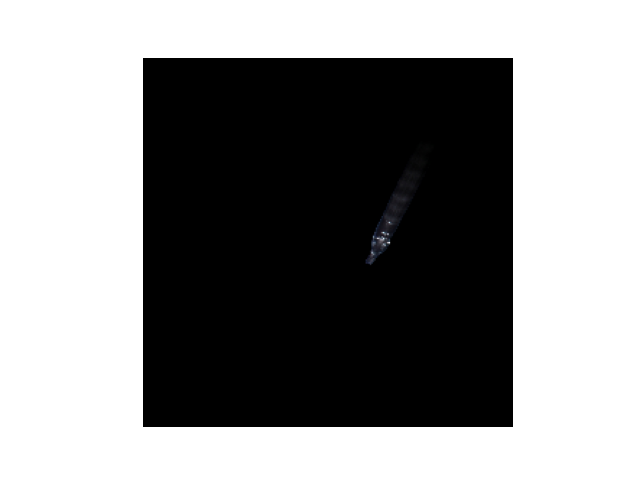

Reference image shape: torch.Size([3, 256, 256])
70.48579406738281


In [ ]:
## ------ Display Reference Image ------ ##
original_image_path = "/home/iulian/chole_ws/src/sam2/data/atracsys_data/r_1/0000.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/data/atracsys_data/r_1_segment_results/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/mask_2.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/segmented_tool_8_0.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_77/1_grabbing_gallbladder/20240907-090634-569257/left_img_dir/frame000017_left.jpg"  # Path to your reference image

fig = plt.figure()


## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')

## crop the image to be square
# reference_image = np.array(reference_image)[:540, :540]
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = Utils.pad_to_match_aspect(reference_image, 1.0)

reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
reference_image_small = F.interpolate(reference_image.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False).squeeze(0)

plt.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("Reference image shape:", reference_image.shape)  # Expected: [3, H, W]

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
normalization_factor = torch.sum(reference_image ** 2).item()  # Sum of squared pixel values
print(normalization_factor)

In [ ]:
def compute_initial_position(reference_image):
    # Create a mask where a pixel is non-black if the sum over channels is greater than zero.
    mask = (reference_image.sum(dim=0) > 0.1)
    
    # Count the number of non-black pixels.
    count = int(mask.sum().item())
    
    # If no non-black pixel is found, return count and a default center.
    if count == 0:
        return (None, None)
    
    # Get indices (row, col) of non-black pixels.
    indices = torch.nonzero(mask)  # shape: (num_nonblack, 2)
    
    # Compute the average center as the mean of row indices and column indices.
    avg_coords = indices.float().mean(dim=0)
    average_center = (avg_coords[0].item(), avg_coords[1].item())
    
    return average_center

average_center=compute_initial_position(reference_image)
print("average center:",average_center)

average center: (100.29878997802734, 176.61904907226562)


In [ ]:
model = PoseNet().to("cuda")
(model_params, trained_iter) = torch.load("./output/LND_pose_train_t/pose_net_chkpnt_16000.pth")

model.load_state_dict(model_params)

model.eval()  # Set to evaluation mode

output = model(reference_image_small.unsqueeze(0))
print(output)

## turn the output to homogenous transformation matrix
trans = output[0, :3]
rot = output[0, 3:]
print(rot)
rot = rot / torch.norm(rot)
## rot format: [qw, qx, qy, qz] -> [qx, qy, qz, qw]
# rot = torch.cat([rot[1:], rot[:1]]) 
print(rot)
rot = rot.cpu().detach().numpy()
## turn quaternion to rotation matrix
rot_matrix = Rotation.from_quat(rot).as_matrix()

pose = np.eye(4)
pose[:3, :3] = rot_matrix
pose[:3, 3] = trans.cpu().detach().numpy()

print(pose)

/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[-0.0526, -0.1742,  0.1886, -0.1462, -0.1350,  0.1026, -0.9746]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([-0.1462, -0.1350,  0.1026, -0.9746], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-0.1462, -0.1350,  0.1026, -0.9746], device='cuda:0',
       grad_fn=<DivBackward0>)
[[ 0.94249313  0.23947738  0.23314648 -0.05258242]
 [-0.16054522  0.93620967 -0.31262867 -0.17418094]
 [-0.29314149  0.25721982  0.92081813  0.188604  ]
 [ 0.          0.          0.          1.        ]]


/tmp/ipykernel_2879088/1289993826.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (model_params, trained_iter) = torch.load("./output/LND_pose_train_t/pose_net_chkpnt_16

tensor(22938, device='cuda:0')
tensor([[-0.0032,  0.0014, -0.0125],
        [-0.0032,  0.0022, -0.0124],
        [-0.0031,  0.0012, -0.0117]], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(29749, device='cuda:0')


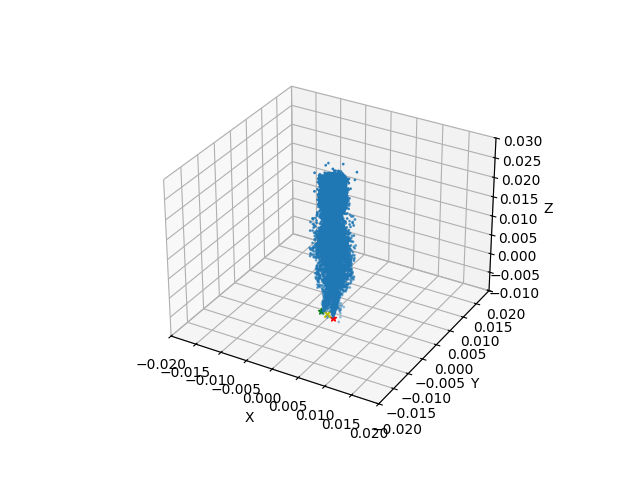

In [ ]:
## plot the canonical gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.02, 0.02)
ax.set_ylim(-0.02, 0.02)
ax.set_zlim(-0.01, 0.03)
# ax.set_xlim(-0.035, 0.035)
# ax.set_ylim(-0.035, 0.035)
# ax.set_zlim(-0.51, -0.44)
ax.scatter(gaussians._xyz[:, 0].detach().cpu().numpy(), gaussians._xyz[:, 1].detach().cpu().numpy(), gaussians._xyz[:, 2].detach().cpu().numpy(), s=1)

# ## find the point with min z value and its index
min_z, min_z_idx = torch.min(gaussians._xyz[:, 2], 0)
print(min_z_idx)
ax.scatter(gaussians._xyz[min_z_idx, 0].detach().cpu().numpy(), gaussians._xyz[min_z_idx, 1].detach().cpu().numpy(), gaussians._xyz[min_z_idx, 2].detach().cpu().numpy(), s=20, c='r', marker='*')

# ## find the point with abs value of x < 0.0005 and z < -0.5 with min y value and its index
filtered_indices = torch.logical_and(gaussians._xyz[:, 0] < -0.003, gaussians._xyz[:, 2] < -0.005)
filtered_points = gaussians._xyz[filtered_indices]
print(filtered_points)
min_y, min_y_idx = torch.min(filtered_points[:, 1], 0)
original_min_y_idx = torch.nonzero(filtered_indices)[min_y_idx][0]
print(original_min_y_idx)
ax.scatter(gaussians._xyz[original_min_y_idx, 0].detach().cpu().numpy(), gaussians._xyz[original_min_y_idx, 1].detach().cpu().numpy(), gaussians._xyz[original_min_y_idx, 2].detach().cpu().numpy(), s=20, c='g', marker='*')

# ## find middle point between the two points
middle_point = (gaussians._xyz[min_z_idx] + gaussians._xyz[original_min_y_idx]) / 2
ax.scatter(middle_point[0].detach().cpu().numpy(), middle_point[1].detach().cpu().numpy(), middle_point[2].detach().cpu().numpy(), s=20, c='y', marker='x')


plt.show()


In [ ]:
import copy
def grid_search_best_pose(average_center,example_camera, gaussians, background_color, reference_image, home_pose, divide_number_angle, divide_number_pos):

    # Create “master” copies of inputs that should remain unchanged across loops.
    # For tensors, use .clone(); for other mutable objects, use deepcopy.
    original_gaussians = copy.deepcopy(gaussians)
    original_background_color = copy.deepcopy(background_color)
    if torch.is_tensor(reference_image):
        original_reference_image = reference_image.clone()
    else:
        original_reference_image = copy.deepcopy(reference_image)
    
    best_final_loss = float('inf')
    best_initial_loss = float('inf')
    best_final_loss_index = None
    best_initial_loss_index = None

    num_combinations = divide_number_angle * (divide_number_pos ** 2)  # Total number of combinations
    for i in range(num_combinations):
        # Deepcopy the camera so that changes in one loop do not affect others.
        camera_copy = copy.deepcopy(example_camera)
        # Generate the initial pose using the provided index.
        T_rotated_torch = generate_initial_pose(camera_copy, divide_number_angle, divide_number_pos, i, average_center)
        camera_copy.world_view_transform = T_rotated_torch
        
        # Initialize parameters using copies.
        joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")
        world_view_transform_result = camera_copy.world_view_transform.clone().detach().to("cuda").requires_grad_(True)

        # Define learning rates.
        joint_pose_lr = 1e-3
        translation_lr = 1e-4

        # Create a fresh optimizer for this iteration.
        optimizer = torch.optim.Adam([
            {"params": joint_pose_result, "lr": joint_pose_lr},
            {"params": world_view_transform_result, "lr": translation_lr},
        ])

        num_iterations = 100
        loss_fn = torch.nn.MSELoss()
        video = []

        # Create fresh copies of the remaining inputs.
        gaussians_copy = copy.deepcopy(original_gaussians)
        background_color_copy = copy.deepcopy(original_background_color)
        if torch.is_tensor(original_reference_image):
            reference_image_copy = original_reference_image.clone()
        else:
            reference_image_copy = copy.deepcopy(original_reference_image)

        # Run the optimization function using the copied inputs.
        video, joint_pose_result_out, world_view_transform_result_out, pc, loss = \
            Utils.optimization_w2v(
                camera_copy, gaussians_copy, background_color_copy, reference_image_copy,
                loss_fn, optimizer, joint_pose_result, world_view_transform_result,
                num_iterations=num_iterations, plot=False
            )
        final_loss=loss[-1]
        initial_loss=loss[0]
        final_render = torch.clamp(render(camera_copy, gaussians_copy, background_color_copy)['render'], 0, 1)
        padded_rendered_image = Utils.pad_to_match_aspect(final_render, target_aspect_ratio)

        # Convert images for visualization
        rendered_image_np = padded_rendered_image.detach().permute(1, 2, 0).cpu().numpy()

        count, _=compute_nonblack_statistics(rendered_image_np)
        print(count)
        
        
        final_loss=final_loss/count
        initial_loss=initial_loss/count

        # Track the best losses along with the corresponding index.
        if final_loss < best_final_loss:
            best_final_loss = final_loss
            best_final_loss_index = i

        if initial_loss < best_initial_loss:
            best_initial_loss = initial_loss
            best_initial_loss_index = i

    return best_final_loss_index, best_initial_loss_index



def generate_initial_pose(example_camera, divide_number_angle, divide_number_pos, index, average_center):
    # Return the "index"th combination out of divide_number_angle * (divide_number_pos^2) total combinations.

    example_camera = sample_cameras[0]

    ## Customize camera parameters
    cam = mujoco.MjvCamera()
    mujoco.mjv_defaultCamera(cam)
    cam.distance = 0.1
    cam.azimuth = -50.0
    cam.elevation = -10
    cam.lookat = (0, 0, -0.0)
    w2v = compute_camera_extrinsic_matrix(cam)
    
    t0_up=min((average_center[1]-128)/256*0.08+0.01,0.04)
    t0_down=max((average_center[1]-128)/256*0.08-0.01,-0.04)
    t1_up=min((average_center[0]-128)/256*0.08+0.01,0.04)
    t1_down=max((average_center[0]-128)/256*0.08-0.01,-0.04)

    # Generate uniformly spaced values for theta, t[0] and t[1]
    thetas = np.linspace(-np.pi, np.pi, divide_number_angle)
    t0_vals = np.linspace(t0_down, t0_up, divide_number_pos)
    t1_vals = np.linspace(t1_down, t1_up, divide_number_pos)

    
    # Compute the combination indices:
    # Total combinations = divide_number_angle * (divide_number_pos)^2
    d_pos = divide_number_pos
    theta_idx = index // (d_pos * d_pos)
    remainder = index % (d_pos * d_pos)
    t0_idx = remainder // d_pos
    t1_idx = remainder % d_pos
    
    theta = thetas[theta_idx]

    ## Rotate the view using the computed theta
    R_z = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

    R = w2v[:3, :3]
    t = w2v[:3, 3].copy()  # Make a copy to avoid modifying the original
    
    t[0] = t0_vals[t0_idx]
    t[1] = t1_vals[t1_idx]
    t[2] =0.1

    print(index, theta,t[0],t[1])
    # Apply the rotation
    R_rotated = R_z @ R  # Rotate the original rotation matrix
    t_rotated = t       # Use the modified translation vector

    # Combine back into a transformation matrix
    T_rotated = np.eye(4)
    T_rotated[:3, :3] = R_rotated
    T_rotated[:3, 3] = t_rotated

    T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype)\
                            .transpose(0, 1)\
                            .to(example_camera.data_device)
    return T_rotated_torch

def compute_nonblack_statistics(rendered_image_np):
    gray = rendered_image_np.sum(axis=2)
    
    # Create a mask for non-black pixels. A pixel is considered non-black if its sum > 0.
    mask = gray > 0.03
    
    # Count the number of non-black pixels.
    count = int(np.sum(mask))
    
    # If there are no non-black pixels, return count and a default center.
    if count == 0:
        return 0.00001, (None, None)
    
    # Get the indices (row, col) of non-black pixels.
    indices = np.argwhere(mask)
    
    # Compute the average coordinates (mean of rows and columns).
    average_center = indices.mean(axis=0)
    
    return count, (average_center[0], average_center[1])
    

In [ ]:
home_pose = [0.0, 0.0, 0.0]
angle_divide_num=36
distance_divide_num=1
best_final_loss_index, best_initial_loss_index=grid_search_best_pose(average_center, example_camera, gaussians, background_color, reference_image, home_pose, angle_divide_num,distance_divide_num)
print("Best final loss index:", best_final_loss_index)
print("Best initial loss index:", best_initial_loss_index)

0 -3.141592653589793 0.008991816043853762 -0.020820785164833072


 94%|█████████▍| 283/300 [00:03<00:00, 71.01it/s]


KeyboardInterrupt: 

In [ ]:
## ------ Configure Camera Parameters ------ ##
example_camera = sample_cameras[0]

## Customize camera parameters
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.1
cam.azimuth = -50.0
cam.elevation = -10
cam.lookat = (0,0,-0.0)
w2v = compute_camera_extrinsic_matrix(cam)

print("Extrinsics:\n", w2v)

# # w2v = getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)
# # print(w2v)

# ## rotate the view
# theta = np.pi/8  # 90 degrees in radians
# R_z = np.array([
#     [np.cos(theta), -np.sin(theta), 0],
#     [np.sin(theta),  np.cos(theta), 0],
#     [0,              0,             1]
# ])

# R = w2v[:3, :3]
# t = w2v[:3, 3]

# # Apply translation
# # t[0] = -0.5
# # t[1] = 0.02
# # t[0] -= 0.06
# # t[1] += 0.03
# t[0] = -0.040
# t[1] = 0

# # Apply the rotation
# R_rotated = R_z @ R  # Rotate the original rotation matrix
# t_rotated = t  # Rotate the translation vector

# # Combine back into a transformation matrix
# T_rotated = np.eye(4)
# T_rotated[:3, :3] = R_rotated
# T_rotated[:3, 3] = t_rotated


# # T_rotated = np.array([[ 9.61261696e-01, -2.75637356e-01,  0.00000000e+00,  0.00000000e+00],
# #  [-2.17205200e-01, -7.57484553e-01, -6.15661475e-01,  6.93889390e-18],
# #  [ 1.69699301e-01,  5.91811794e-01, -7.88010754e-01,  1.37775712e-01],
# #  [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)

T_rotated_torch=generate_initial_pose(example_camera, angle_divide_num,distance_divide_num, best_final_loss_index, average_center)

example_camera.world_view_transform = T_rotated_torch
print("TWV:\n", example_camera.world_view_transform)



In [ ]:
## ------ Render Init Gaussian ------ ##
n = len(kinematic_chain.get_joint_parameter_names())  
print(kinematic_chain.get_joint_parameter_names())  
# home_pose = [0.2, 0.3, 0.222, -0.203, 0.257]
home_pose = [0.0, 0.0, 0.0]
# example_camera = sample_cameras[0]
# home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
example_camera.joint_pose = torch.tensor(home_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)
# with torch.no_grad():  # Ensure no gradient tracking for direct modification
#     gaussians._xyz[:, 0] -= 0.01  # translation

theta = -np.pi /2   # Example: 45-degree rotation
R_z = torch.tensor([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
], dtype=torch.float32, device=gaussians._xyz.device)

R_x = torch.tensor([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
], dtype=torch.float32, device=gaussians._xyz.device)

# gaussians._xyz = torch.matmul(gaussians._xyz, R_z.T)  # Transpose R_z for proper multiplication
result = render(example_camera, gaussians, background_color)

# fig = plt.figure()

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
pc = result['pc'].detach().cpu().numpy() # Point cloud, directly from render_points

fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_xlim(-0.02, 0.02)
# ax.set_ylim(-0.02, 0.02)
# ax.set_zlim(-0.01, 0.03)
# ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)

# # plot min z point
# ax.scatter(pc[min_z_idx, 0], pc[min_z_idx, 1], pc[min_z_idx, 2], s=20, c='r', marker='*')

# # plot min y point
# ax.scatter(pc[original_min_y_idx, 0], pc[original_min_y_idx, 1], pc[original_min_y_idx, 2], s=20, c='g', marker='*')

# middle_point = (pc[min_z_idx] + pc[original_min_y_idx]) / 2
# ax.scatter(middle_point[0], middle_point[1], middle_point[2], s=20, c='y', marker='x')

# plt.show()


frame = mask  # Use the mask directly without clamping or thresholding

# Display the mask (optional, normalized for visualization)
Utils.display_render(torch.clamp(mask, 0, 1))

print("w2v:", example_camera.world_view_transform)
# frame.sum().backward()

# print('Sum of joint gradients:', example_camera.joint_pose.grad.sum())
# print('Sum of camera gradients:', example_camera.world_view_transform.grad.sum())

### Optimization

In [ ]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().to("cuda").requires_grad_(True) # Initial camera transform
print(joint_pose_result)
print(world_view_transform_result)
# Define different learning rates
# joint_pose_lr = 2e-4
# world_transform_lr = 1e-4

joint_pose_lr = 1e-3
rotation_lr = 1e-4
translation_lr = 1e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# quat, translation = decompose_homogeneous_matrix_quaternion(example_camera.world_view_transform.clone().detach().cpu())
# quat = torch.nn.Parameter(quat, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": quat, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
num_iterations = 500

loss_fn = torch.nn.MSELoss()
video = []


In [ ]:

fig = plt.figure()
# Optimization loop
video, joint_pose_result, world_view_transform_result, pc= Utils.optimization_w2v(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations, plot=True)
# video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization_quat(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)

# Final results
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


In [ ]:
## ------ Save the video ------ ##
Utils.make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

## ------ Compare the final rendered image and the reference image with overlay ------ ##
final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)
padded_rendered_image = Utils.pad_to_match_aspect(final_render, target_aspect_ratio)

# Convert images for visualization
rendered_image_np = padded_rendered_image.detach().permute(1, 2, 0).cpu().numpy()
ground_truth_image_np = reference_image.permute(1, 2, 0).cpu().numpy()

# Alpha blending (overlay with transparency)
alpha = 0.3  # Transparency factor
blended_image = (alpha * rendered_image_np + (1 - alpha) * ground_truth_image_np)

# Extract silhouette using threshold and contour detection
rendered_mask = np.any(rendered_image_np > 0.05, axis=-1)  # Threshold for silhouette detection
contours = measure.find_contours(rendered_mask.astype(float), 0.5)

## Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Ground Truth
ax = axs[0]
ax.set_title("Ground Truth Image")
ax.imshow(original_image)
ax.axis('off')

# Mask (if required)
# ax = axs[1]
# ax.set_title("Original Mask")
# ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
# ax.axis('off')

# Rendered Image
ax = axs[1]
ax.set_title("Rendered Image")
ax.imshow(rendered_image_np)
ax.axis('off')

# Blended Visualization with Silhouette
ax = axs[2]
ax.set_title("Overlay with Silhouette")
ax.imshow(blended_image)

# Draw silhouette contours on the blended image
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('off')

# plt.tight_layout()
plt.show()


In [ ]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/data/atracsys_data/r_1/"

# Count the number of files and prepare the image list
imgs = []
image_num = Utils.count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"image_{i:04d}.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]

    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = Utils.pad_to_match_aspect(img, 1.0)
    
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

Utils.make_video(imgs, filename="r_1")

IPImage(filename="r_1.gif")

In [ ]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/data/atracsys_data/r_1_segment_results/"

# Count the number of files and prepare the image list
imgs = []
image_num = Utils.count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]

    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = Utils.pad_to_match_aspect(img, 1.0)
    
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

Utils.make_video(imgs, filename="mask_r_1")

IPImage(filename="mask_r_1.gif")
# plt.imshow(imgs[30].permute(1,2,0).detach().cpu().numpy())
# plt.axis('off')

In [ ]:

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos = ee_l_qpos - ee_l_qpos_init

# best_config, best_errors = optimize_and_tune(
#     example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
#     world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=10,
#     max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
# )

In [ ]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []
pc_results = {}
# Optimization loop
num_iterations = 10
# Define different learning rates
# joint_pose_lr = 5e-4
# rotation_lr = 1
# translation_lr = 3e-5

joint_pose_lr = 8e-4
translation_lr = 5e-5
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": euler_angles, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
for n, img in enumerate(imgs):
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result, pc = Utils.optimization_kalman(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, pc = Utils.optimization_w2v(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization_quat(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result.clone().detach())
    world_view_transform_results.append(world_view_transform_result.clone().detach())
    pc_results[n] = pc.detach().cpu().numpy()

    # euler_results.append(euler_result.clone().detach())
    # trans_results.append(trans_result.clone().detach())
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


In [ ]:
## ------ Save the video ------ ##
Utils.make_video(videos, "./eval/tracking_sequence_r_1")
IPImage(filename="./eval/tracking_sequence_r_1.gif")
# plt.figure()
# plt.imshow(videos[30].permute(1,2,0).detach().cpu().numpy())
# plt.axis('off')


In [ ]:
IPImage(filename="mask_r_1.gif")


In [ ]:
def make_video_overlay(video1, video2, filename, fps=30):
    video1 = Utils.process_video(video1)
    video2 = Utils.process_video(video2)
    video = []
    for i in range(len(video1)):
        overlay = cv2.addWeighted(video1[i], 0.3, video2[i], 0.8, 0)
        rendered_mask = np.any(video1[i] > 0.3, axis=-1)  # Threshold for silhouette detection
        contours = measure.find_contours(rendered_mask.astype(float), 0.8)
        # Draw the contours on the overlay
        for contour in contours:
            overlay[np.round(contour[:, 0]).astype(int), np.round(contour[:, 1]).astype(int)] = [100, 120, 230]

        video.append(overlay)

    clip = ImageSequenceClip(list(video), fps=fps)
    clip.write_gif(f"{filename}.gif")

make_video_overlay(videos, imgs, filename="tracking_sequence_overlay_r_1")
IPImage(filename="tracking_sequence_overlay_r_1.gif")

In [ ]:
trans_results = []
T_tc_list = []

P = sample_cameras[2].projection_matrix
# P = K.inverse()
# P = example_camera.projection_matrix
# P[0,0] = 30.0
# P[1,1] = 30.0
# P[0,2] = -5.0
# P[1,2] = 10.0
# P[2,2] = 1.0
# P[3,2] = 0.0
# print(P)
tool_poses = []
image_width = 256
image_height = 256
original_image_width = 1920
original_image_height = 1080
# original_image_width = 960
# original_image_height = 540
# print("TWC:", world_view_transform_results[0].T)
# print(torch.inverse(world_view_transform_results[0]))

def invert_T(T):
    R = T[..., :3, :3]
    t = T[..., :3, [-1]]
    R_inv = R.transpose(-2, -1)
    t_inv = - R_inv @ t
    T_inv = T.clone()
    T_inv[..., :3, :3] = R_inv
    T_inv[..., :3, [-1]] = t_inv
    return T_inv

for n, w in enumerate(world_view_transform_results):

    ## calculate middle point
    middle_point = (pc_results[n][min_z_idx] + pc_results[n][original_min_y_idx]) / 2


    R_x_180 = torch.tensor([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, -1]
    ], device='cuda:0')

    middle_point_homogeneous = torch.cat([torch.tensor(middle_point, device='cuda:0'), torch.tensor([1.0], device='cuda:0')])
    T_wt_homogeneous = torch.eye(4, device='cuda:0')
    T_wt_homogeneous[:3, :3] = R_x_180
    T_wt_homogeneous[:3, 3] = middle_point_homogeneous[:3]
    # print("TWT\n", T_wt_homogeneous)

    # T_wc = w.transpose(1, 0)
    T_wc = w  #.transpose(1, 0)

    # Inverse of the world to camera transformation matrix (to transform from world to camera)
    T_wc_inv = invert_T(T_wc.transpose(1, 0))
    # print("TWC inv\n", T_wc_inv)

    # Calculate the position of the surgical tool in the camera frame
    T_tc_homogeneous = T_wt_homogeneous.T @ T_wc
    # T_tc_homogeneous_real = T_wc_inv @ T_wt_homogeneous

    # P = example_camera.projection_matrix
    # P = original_camera_matrix
    # print(P)
    projected_pose = P.T.detach().cpu() @ T_tc_homogeneous.detach().cpu()
    # projected_pose = T_tc_homogeneous[:4].detach().cpu() @ P

    # Normalize by the homogeneous coordinate (w) to get 2D image coordinates
    # x_2d = projected_pose[0] / projected_pose[2]
    # y_2d = projected_pose[1] / projected_pose[2]
    x_2d = ((projected_pose[0] / projected_pose[2] + 1) * 0.5) * image_width
    y_2d = ((projected_pose[1] / projected_pose[2] + 1) * 0.5) * image_height
    # x_2d = (x_2d ) * image_width
    # y_2d = (y_2d ) * image_height
    tool_pose = (x_2d, y_2d)
    # Extract the position of the surgical tool in the camera frame (ignoring the homogeneous coordinate)

    T_tc_list.append(T_tc_homogeneous.detach().cpu().numpy().transpose(1, 0))
    # print(T_tc_homogeneous_real[:3].detach().cpu().numpy(), T_tc_homogeneous[:3].detach().cpu().numpy())

    tool_poses.append(tool_pose)

print("TTC",T_tc_list)
# print("Surgical tool pose relative to the camera frame:", T_tc_list)
# print(P)
# print(T_wc)
# print(tool_poses[0])
# # print(T_tc_list - T_tc_list[0])
# for n in range(len(tool_poses)):
#     print(f"Frame {n}: {tool_poses[n][0] - tool_poses[0][0]}")


# print(torch.matmul())
# trans_results = world_view_transform_results[:][:3, 3]

In [ ]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for T_tc in T_tc_list:
    ax.scatter(T_tc[0], T_tc[1], T_tc[2], c="r")
ax.view_init(180, 180)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title("Relative action trajectory") 
plt.show()

In [ ]:
t_results = []

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(original_image)
tool_poses_init = tool_poses[0]
print(tool_poses_init[0], tool_poses_init[1])
scale = original_image_width/image_width
offset = (original_image_width - original_image_height) /2
starting_point = [tool_poses_init[0] * scale, tool_poses_init[1] * scale]
print(starting_point[0], starting_point[1] - offset)
# starting_point = [298.73125, 398.9125]
# starting_point = tool_poses_init
ax.imshow(original_image)
for num in range(len(tool_poses)):
    tool_pose_x = scale * (tool_poses[num][0])# - tool_poses_init[0]) + starting_point[0]
    tool_pose_y = scale * (tool_poses[num][1]) - offset # - tool_poses_init[1]) + starting_point[1]
    t_results.append([tool_pose_x, tool_pose_y])
    ax.scatter(tool_pose_x, tool_pose_y, c="b")

In [ ]:

starting_point = tool_poses_init
# starting_point = [30, 160]
scale = 1
tool_poses_init = tool_poses[0]

# scale = 256/960
fig = plt.figure(figsize=(10, 10))

def display_render_traj(image_tensor: torch.Tensor, tool_poses: list = None):
    pose_results = []
    im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    im = (im * 255).astype(np.uint8)
    plt.imshow(im)
    for num in range(len(tool_poses)):
        tool_pose_x = scale * (tool_poses[num][0] - tool_poses_init[0]) + starting_point[0]
        tool_pose_y = scale * (tool_poses[num][1] - tool_poses_init[1]) + starting_point[1]
        plt.scatter(tool_pose_x, tool_pose_y, c="b", s=10)
        pose_results.append([tool_pose_x, tool_pose_y])
    # plt.axis('off')
    plt.show()
    return pose_results


pose_results = display_render_traj(videos[0], tool_poses)


In [ ]:
# # for num in range(len(tool_poses)):
# #     tool_pose_x = scale * (tool_poses[num][0] - tool_poses[0][0]) + starting_point[0]
# #     tool_pose_y = scale * (tool_poses[num][1] - tool_poses[0][1]) + starting_point[1]
# #     pose_results.append([tool_pose_x, tool_pose_y])

# def display_render_traj_frame(image_tensor: torch.Tensor, pose_results: list):
#     im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
#     im = (im * 255).astype(np.uint8)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.imshow(im)
#     # Plot the trajectory
#     for n in range(len(pose_results)):
#         tool_pose_x = pose_results[n][0]
#         tool_pose_y = pose_results[n][1]
#         ax.scatter(tool_pose_x, tool_pose_y, c="r", s=10)
#     plt.axis('off')
#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.close(fig)
#     return image

# # Generate the GIF frames
# frames = []
# for frame_tensor in videos:
#     frame = display_render_traj_frame(frame_tensor, pose_results)
#     frames.append(frame)

# # Save the GIF
# filename = "./trajectory_render"
# clip = ImageSequenceClip(list(frames), fps=30)
# clip.write_gif(f"{filename}.gif")
# print(f"GIF saved at: {filename}")

In [ ]:
ee_label_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_18/1_grabbing_gallbladder_recovery/20240719-160046-708534_recovery/ee_labels.csv"
# ee_label_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_18/1_grabbing_gallbladder_recovery/20240719-160046-708534_recovery/ee_labels.csv"
ee_label = pd.read_csv(ee_label_path)
ee_label = ee_label[["ee_PSM2_x", "ee_PSM2_y"]].to_numpy()
ee_init = ee_label[0]
# ee_label = (ee_label - ee_init)
print(ee_init)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(original_image)

for a in ee_label:
    ax.scatter(a[0], a[1], c="r")

for a in t_results:
    ax.scatter(a[0], a[1], c="b")

plt.show()

In [ ]:




## use ee_label and t_results to calculate reprojection error
rep_error = []
for n in range(len(ee_label)):
    error = np.linalg.norm(ee_label[n] - t_results[n])
    rep_error.append(error)
    # print(f"Frame {n}: {np.linalg.norm(ee_label[n] - t_results[n])}")

## calculate the mean reprojection error
mean_rep_error = np.mean(rep_error)
print(f"Mean reprojection error: {mean_rep_error}")

fig = plt.figure()
plt.plot(rep_error)




In [ ]:
# quaternion to rotation matrix
def quaternion_to_rotation_matrix(quaternion):
    """
    Convert a quaternion to a rotation matrix.

    Args:
        quaternion: A list containing the quaternion [x, y, z, w].

    Returns:
        A 3x3 rotation matrix.
    """
    x, y, z, w = quaternion
    rotation_matrix = np.array([
        [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x**2 - 2 * y**2]
    ])
    return rotation_matrix

## read the csv file
ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1_cp.csv"
# ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1.csv"

# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
ee_l_qpos = ee_csv.to_numpy()

## ee_l_qpos is the ground truth trajectory format [x, y, z, qx, qy, qz, qw]
# print(ee_l_qpos[0])
# print(T_tc_list[0])



## homogeneous transformation matrix for the first frame
# convert quaternion to rotation matrix
R_ee_init = quaternion_to_rotation_matrix(ee_l_qpos[0][3:])
T_ee_init = ee_l_qpos[0][:3]
H_ee_init = np.eye(4)
H_ee_init[:3, :3] = R_ee_init
H_ee_init[:3, 3] = T_ee_init
# print(H_ee_init)

## calculate the relative action trajectory against the first frame of the ground truth trajectory
relative_action = []
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for r in ee_l_qpos:
    H_ee = np.eye(4)
    H_ee[:3, 3] = r[:3]
    H_ee[:3, :3] = quaternion_to_rotation_matrix(r[3:])
    print(H_ee)
    H_ee_relative = np.linalg.inv(H_ee_init) @ H_ee
    relative_action.append(H_ee_relative)
    # print(H_ee_relative[:3, 3])
    ax.scatter(H_ee_relative[0, 3], H_ee_relative[1, 3], H_ee_relative[2, 3], c="r")
# print(relative_action[0][:3, 3])


## calculate the relative action trajectory against the first frame of the estimated trajectory
relative_action_est = []
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
H_tc_init = np.eye(4)
H_tc_init[:3, 3] = T_tc_list[0][:3]
# R_z = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
theta = -np.pi /2   # Example: 45-degree rotation
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])
theta_1 = np.pi /2   # Example: 45-degree rotation

R_x = np.array([
    [1, 0, 0],
    [0, np.cos(theta_1), -np.sin(theta_1)],
    [0, np.sin(theta_1), np.cos(theta_1)]
])



# R_x = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
# R_y = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])
# H_tc_init[:3, :3] = R_z @ R_x
# H_tc_init[:3, :3] = R_y @ R_x @ R_z
## apply rotation to z axis for the first frame
# H_tc_init[:3, :3] = np.array([[0,1, 0], [-1, 0, 0], [0, 0, 1]])

print(H_tc_init)
for r in T_tc_list:
    H_est = np.eye(4)
    H_est[:3, 3] = r[:3]
    # H_est[:3, :3] = np.array([[0,-1, 0], [1, 0, 0], [0, 0, 1]])

    H_est[:3, :3] = np.eye(3)
    # print(H_est)
    H_est_relative = np.linalg.inv(H_est) @ H_tc_init 
    relative_action_est.append(H_est_relative)
    # print(H_est_relative[:3, 3])
    ax.scatter(H_est_relative[0, 3], H_est_relative[1, 3], H_est_relative[2, 3], c="b")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(0, 0.04)
# ax.set_ylim(-0.02, 0.02)
# ax.set_zlim(-0.03, 0.01)
ax.view_init(0, 0)
plt.title("Relative action trajectory")
plt.show()
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos_relative = ee_l_qpos - ee_l_qpos_init
# results = []
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# trans_init = [T_tc_list[0][0], T_tc_list[0][1] , T_tc_list[0][2]]
# print(ee_l_qpos_init[:3])
# print(trans_init)
# print(T_tc_list[0])
# # print(T_tc_list - T_tc_list[0])

# count = 0
# scale = 256/960
# for r in T_tc_list:
#     res = scale * (T_tc_list[0] - r)
#     results.append([res[0], res[1], res[2]])
#     ax.scatter(res[0], res[1], res[2], c="b")
#     count += 1
#     # if count>50: 
#         # break
# # # plt.show()
# # ax = fig.add_subplot(121, projection='3d')
# ax.scatter(ee_l_qpos_relative[:, 0], ee_l_qpos_relative[:, 1], ee_l_qpos_relative[:, 2], c="r")
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos_relative = ee_l_qpos - ee_l_qpos_init
# results = []
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# trans_init = [T_tc_list[0][0], T_tc_list[0][1] , T_tc_list[0][2]]
# print(ee_l_qpos_init[:3])
# print(trans_init)
# print(T_tc_list[0])
# # print(T_tc_list - T_tc_list[0])

# count = 0
# scale = 256/960
# for r in T_tc_list:
#     res = scale * (T_tc_list[0] - r)
#     results.append([res[0], res[1], res[2]])
#     ax.scatter(res[0], res[1], res[2], c="b")
#     count += 1
#     # if count>50: 
#         # break
# print(results)

In [ ]:
def quaternion_to_rotation_matrix(quaternion):
    """
    Convert a quaternion to a rotation matrix.

    Args:
        quaternion: A list containing the quaternion [x, y, z, w].

    Returns:
        A 3x3 rotation matrix.
    """
    x, y, z, w = quaternion
    rotation_matrix = np.array([
        [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x**2 - 2 * y**2]
    ])
    return rotation_matrix
def estimate_transformation(pts_gt, pts_est):
    """
    Estimate the rigid transformation (R, t) that aligns pts_est to pts_gt.
    
    Args:
        pts_gt:  (N, 3) array of ground truth 3D points.
        pts_est: (N, 3) array of estimated 3D points.

    Returns:
        R (3x3 rotation matrix), t (3x1 translation vector)
    """
    # Compute centroids
    centroid_gt = np.mean(pts_gt, axis=0)
    centroid_est = np.mean(pts_est, axis=0)
    
    # Center the points
    P_prime = pts_gt - centroid_gt
    Q_prime = pts_est - centroid_est
    
    # Compute the covariance matrix
    H = Q_prime.T @ P_prime
    
    # Compute SVD
    U, S, Vt = np.linalg.svd(H)
    
    # Compute rotation
    R = Vt.T @ U.T
    
    # Ensure proper rotation (det(R) should be 1, not -1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    
    # Compute translation
    t = centroid_gt - R @ centroid_est
    
    return R, t

In [ ]:

# plt.close('all')
# import time
# time.sleep(1)
# quaternion to rotation matrix

## read the csv file
ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1_cp.csv"

atracsys_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1.csv"


# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
atracsys_csv = pd.read_csv(atracsys_csv_path)
ee_l_qpos = ee_csv.to_numpy()
atracsys_pos = atracsys_csv.to_numpy()
## homogeneous transformation matrix for the first frame
# convert quaternion to rotation matrix
R_ee_init = quaternion_to_rotation_matrix(ee_l_qpos[0][3:])
T_ee_init = ee_l_qpos[0][:3]
H_ee_init = np.eye(4)
H_ee_init[:3, :3] = R_ee_init
H_ee_init[:3, 3] = T_ee_init
# print(H_ee_init)

## calculate the relative action trajectory against the first frame of the ground truth trajectory

# print(relative_action[0][:3, 3])

def invert_H(H):
    R = H[:3, :3]
    t = H[:3, 3]
    R_inv = R.transpose()
    t_inv = - R_inv @ t
    H_inv = np.eye(4)
    H_inv[:3, :3] = R_inv
    H_inv[:3, 3] = t_inv
    return H_inv

relative_action = []


## calculate the relative action trajectory against the first frame of the estimated trajectory
relative_action_est = []
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
H_tc_init = np.eye(4)
R_tc_init = quaternion_to_rotation_matrix(atracsys_pos[0][3:])

H_tc_init[:3, 3] = atracsys_pos[0][:3]
H_tc_init[:3, :3] = R_tc_init

# print(H_tc_init)
# R_z = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
theta = -np.pi /2   # Example: 45-degree rotation
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])
theta_1 = -np.pi/2.5   # Example: 45-degree rotation

R_x = np.array([
    [1, 0, 0],
    [0, np.cos(theta_1), -np.sin(theta_1)],
    [0, np.sin(theta_1), np.cos(theta_1)]
])


# H_tc_init[:3, :3] = R_x
# H_tc_init[:3, :3] = R_z @ R_x
# H_tc_init[:3, :3] = R_y @ R_x @ R_z
## apply rotation to z axis for the first frame
# H_tc_init[:3, :3] = np.array([[0,1, 0], [-1, 0, 0], [0, 0, 1]])



# print(H_tc_init)
# H_cam_atracsys = H_tc_init @ invert_H(H_ee_init) 
R, t = estimate_transformation(atracsys_pos[:, :3], ee_l_qpos[:, :3])
print(R, t)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for r in atracsys_pos:
    H_est = np.eye(4)
    H_est[:3, 3] = r[:3]
    # H_est[:3, :3] = np.array([[0,-1, 0], [1, 0, 0], [0, 0, 1]])

    H_est[:3, :3] = np.eye(3)
    # print(H_est)
    H_est_relative = H_est
    # H_est_relative = np.linalg.inv(H_tc_init) @ H_est
    relative_action_est.append(H_est_relative)
    # print(H_est_relative[:3, 3])
    ax.scatter(H_est_relative[0, 3], H_est_relative[1, 3], H_est_relative[2, 3], c="b")

for r in ee_l_qpos:
    H_ee = np.eye(4)
    H_ee[:3, 3] = r[:3]
    H_ee[:3, :3] = quaternion_to_rotation_matrix(r[3:])
    # print(H_ee)
    # H_corrected =  H_ee
    H_ee_relative = (R @ H_ee[:3,3].T).T + t
    # H_ee_relative = invert_H(H_ee_init) @ H_ee
    relative_action.append(H_ee_relative)
    # print(H_ee_relative)
    ax.scatter(H_ee_relative[0], H_ee_relative[1], H_ee_relative[2], c="r")
    # ax.scatter(H_ee_relative[0, 3], H_ee_relative[1, 3], H_ee_relative[2, 3], c="r")
print("ee:", H_ee_relative)
H_render_init = np.eye(4)
H_render_init[:3, 3] = T_tc_list[0][:3, 3]
H_render_init[:3, :3] = T_tc_list[0][:3, :3]

for r in T_tc_list:
    H_render = np.eye(4)
    H_render[:3, 3] = r[:3, 3]
    H_render[:3, :3] = r[:3, :3]
    # H_est[:3, :3] = np.array([[0,-1, 0], [1, 0, 0], [0, 0, 1]])

    # H_render[:3, :3] = np.eye(3)
    # print(H_est)
    H_render_relative = np.linalg.inv(H_render_init) @ H_render 

    H_render_relative =  ((R @ H_render_relative[:3,3].T).T + t)
    relative_action_est.append(H_est_relative)
    # print(H_est_relative[:3, 3])
    ax.scatter(H_render_relative[0], H_render_relative[1], H_render_relative[2], c="g")

print("render",H_render_relative)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(0, 0.04)
# ax.set_ylim(-0.02, 0.02)
# ax.set_zlim(-0.03, 0.01)
# ax.view_init(90, 90)
plt.title("Relative action trajectory")

plt.show()



In [ ]:
## project the 3d points to 2d image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(original_image)
# Set up rasterization configuration
tanfovx = math.tan(example_camera.FoVx * 0.5)
tanfovy = math.tan(example_camera.FoVy * 0.5)

focal_length_x = example_camera.image_width / (2 * tanfovx)
focal_length_y = example_camera.image_height / (2 * tanfovy)
K = torch.tensor(
    [
        [focal_length_x, 0, example_camera.image_width / 2.0, 0],
        [0, focal_length_y, example_camera.image_height / 2.0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ],
    device="cuda",
)

## use projection matrix to project the 3d points to 2d image
# P = K.inverse()
P = sample_cameras[3].projection_matrix
# P[0,2] = 0
# P[1,2] = 0
# P[2,0] = original_image_width / 2
# P[2,1] = original_image_height / 2
print(P.T)
ee_projected = []
scale = 960/256
ee_l_qpos_transform = ee_l_qpos
for n in range(len(ee_l_qpos)):

    T_ee_homogeneous = torch.cat([torch.tensor(ee_l_qpos_transform[n][:3], device='cuda:0'), torch.tensor([1.0], device='cuda:0')])
    print(T_ee_homogeneous)
    # print(ee_l_qpos_transform[n][:3])
    projected_pose = P.T.detach().cpu().numpy() @ T_ee_homogeneous[:4].detach().cpu().numpy()
    x_2d = ((projected_pose[0] / projected_pose[2] + 1) * 0.5) * original_image_width
    y_2d = ((projected_pose[1] / projected_pose[2] + 1) * 0.5) * original_image_width
    ee_projected.append([x_2d, y_2d])
    ax.scatter(x_2d, y_2d, c="b")
    ax.scatter(t_results[n][0], t_results[n][1], c="r")



In [ ]:
## plot error between the estimation and the ground truth
errors = []

n = 2
for i in range(len(ee_l_qpos)):
    error = np.linalg.norm(ee_l_qpos[i, :n] - results[i][:n])

    errors.append(error)

# print(np.linalg.norm(ee_l_qpos[:, :n], axis=1))
fig = plt.figure()
plt.plot(errors)
# plt.plot(np.linalg.norm(ee_l_qpos[:, :n], axis=1), 'r')
plt.xlabel("frame")
plt.ylabel("error (m)")
plt.ylim(0, 0.01)
plt.title("Error (norm) between the estimated and the ground truth")
plt.show()

